In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from plot_gameplay_results import heatmap, annotate_heatmap
import math


def load_file(game_id, params):
    file_name = f"Game_{game_id}_{'_'.join(params)}.txt"
    results = np.zeros((20, 3))
    if os.path.exists(file_name):
        with open(file_name, "r") as f:
            for line in f.readlines():
                if "Mean Score" in line:
                    elements = line.split(";")
                    idx = int(elements[0])
                    score = float(elements[1])
                    ticks = float(elements[2].split(":")[1])
                    game_won = True if elements[3].split(":")[1] == "PLAYER_WINS" else False
                    results[idx-1, 0] = score
                    results[idx-1, 1] = ticks
                    results[idx-1, 2] = game_won
    else:
        return (0, 0, 10000, 10000)
    return (np.mean(results[:, 2]), #win-rate
            np.mean(results[:, 0]), #mean score
            np.mean(results[:, 1][results[:, 2] == 1]), # avg. ticks won
            np.mean(results[:, 1][results[:, 2] == 0])) # avg. ticks lost

def store_file(game_id, data_list, parameter_settings):
    with open(f"data/Botdata_{game_id}.csv", "w") as f:
        f.write("Algorithm ; Parameter 1; Parameter 2; Parameter 3; Win-Rate ; Score; Ticks-won; Ticks-Lost\n")
        for data, params in zip(data_list, parameter_settings):
            x = params + list(data)
            f.write(" ; ".join([str(val) for val in x]) + "\n")


game_names = ["aliens", "boulderdash", "butterflies", "chase", "frogs",
              "missilecommand", "portal", "sokoban", "survive zombies", "zelda"]
game_ids = [0, 11, 13, 18, 39, 55, 63, 75, 79, 90]
parameter_settings = [["BFS", "100", "false", "false"],
                      ["BFS", "100", "false", "true"],
                      ["BFS", "100", "true", "false"],
                      ["BFS", "100", "true", "true"],
                      ["BFS", "200", "false", "false"],
                      ["BFS", "200", "false", "true"],
                      ["BFS", "200", "true", "false"],
                      ["BFS", "200", "true", "true"],
                      ["MCTS", "10", "5", "false"],
                      ["MCTS", "10", "5", "true"],
                      ["MCTS", "10", "10", "false"],
                      ["MCTS", "10", "10", "true"],
                      ["MCTS", "20", "5", "false"],
                      ["MCTS", "20", "5", "true"],
                      ["MCTS", "20", "10", "false"],
                      ["MCTS", "20", "10", "true"],
                     ]

ranks = [[0] * 16, [0] * 16, [0] * 16, [0] * 16, [0] * 16, [0] * 16, [0] * 16, [0] * 16,
         [0] * 16, [0] * 16, [0] * 16, [0] * 16, [0] * 16, [0] * 16, [0] * 16, [0] * 16]
points = [0] * 16
game_results = np.zeros((10, 16))
formula = {0: 25, 1: 18, 2: 15, 3: 12, 4: 10, 5: 8, 6: 6, 7: 4, 8: 2, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14:0, 15:0}


all_results = dict()
for (game_idx, game_id), game in zip(enumerate(game_ids), game_names):
    all_results[game_id] = []
    for parameter_setting in parameter_settings:
        results = load_file(game_id, parameter_setting)
        all_results[game_id].append(results)

    store_file(game_id, all_results[game_id], parameter_settings)


    res = [[idx] + [round(y, 2) for y in all_results[game_id][idx]] for idx, _ in enumerate(all_results[game_id])]
    for ind, x in enumerate(res):
        if math.isnan(x[3]):
            res[ind][3] = 10000
        if math.isnan(x[4]):
            res[ind][4] = 10000

    o = sorted(range(len(res)), key=lambda k: (res[k][1], res[k][2], -res[k][3], res[k][4]), reverse=True)
    rank = [0] * 16
    current_rank = 0
    skip = 1
    for io in range(len(o) - 1):
        rank[o[io]] = current_rank
        if res[o[io]][1:15] != res[o[io + 1]][1:15]:
            current_rank += skip
            skip = 1
        else:
            skip += 1
    rank[o[-1]] = current_rank

    # print(game, [res[x][0] for x in o])

    for io, x in enumerate(o):
        ##for p, x in zip([5, 4, 3, 2, 1], o):
        # print(points, res[x][0])
        points[res[x][0]] += formula[rank[o[io]]]

    for j, x in enumerate(o):
        # print(i, x)
        ranks[res[x][0]][rank[o[j]]] += 1
        game_results[game_idx, res[x][0]] = rank[o[j]]

c:\program files\python37\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\program files\python37\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
import pandas as pd

score = [[y] + params + list(res) for y in all_results for res, params in zip(all_results[y], parameter_settings) ]
score
df = pd.DataFrame(score, columns = ["game", "alg", "param1", "param2", "param3", "win-rate", "score", "winning ticks", "losing ticks"])
df_BFS = df[df["alg"]=="BFS"]
df_MCTS = df[df["alg"] == "MCTS"]
df_BFS.columns = ["game", "alg", "expansions", "fast forward prediction", "pruning", "win-rate", "score", "winning ticks", "losing ticks"]
df_MCTS.columns = ["game", "alg", "nr_simulations", "simulation depth", "fast forward prediction", "win-rate", "score", "winning ticks", "losing ticks"]
df_BFS

,game,alg,expansions,fast forward prediction,pruning,win-rate,score,winning ticks,losing ticks
0,0,BFS,100,false,false,0.30,35.05,648.333333,392.642857
1,0,BFS,100,false,true,0.30,36.70,646.500000,399.785714
2,0,BFS,100,true,false,0.15,32.65,642.666667,390.352941
3,0,BFS,100,true,true,0.15,32.95,556.000000,410.647059
4,0,BFS,200,false,false,0.25,32.10,643.600000,319.800000
...,...,...,...,...,...,...,...,...,...
147,90,BFS,100,true,true,0.00,-0.15,NaN,102.950000
148,90,BFS,200,false,false,0.00,-0.55,NaN,204.400000
149,90,BFS,200,false,true,0.00,-0.20,NaN,209.350000
150,90,BFS,200,true,false,0.00,-0.10,NaN,278.000000


Text(0.5, 0.98, 'BFS Parameter Comparison grouped by expansion')

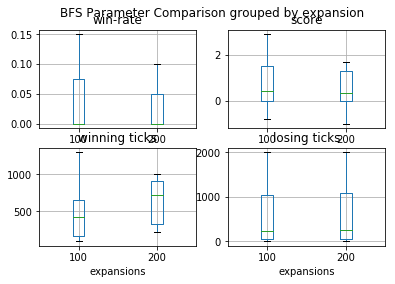

In [3]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, sharey="none")
df_BFS.boxplot(column=['win-rate'],ax = ax1, by='expansions', showfliers=False, return_type=None)
df_BFS.boxplot(column=['score'],ax = ax2, by='expansions', showfliers=False, return_type=None)
df_BFS.boxplot(column=['winning ticks'],ax = ax3, by='expansions', showfliers=False, return_type=None)
df_BFS.boxplot(column=['losing ticks'],ax = ax4, by='expansions', showfliers=False, return_type=None)

fig.suptitle("BFS Parameter Comparison grouped by expansion")


In [ ]:
score = [x[1] for x in all_results[0]]
score
data = [x + [y] for x,y in zip([x[1:] for x in parameter_settings[0:8]], score)]

import pandas as pd
df = pd.DataFrame(data, columns=["expansions", "fast forward prediction", "pruning", "score"])
df
df.groupby(["pruning"]).mean()

fig, ax = plt.subplots(figsize=(5,5))
df.boxplot(column=['score'], by='expansions', ax=ax)

fig, ax = plt.subplots(figsize=(5,5))
df.boxplot(column=['score'], by='fast forward prediction', ax=ax)

fig, ax = plt.subplots(figsize=(5,5))
df.boxplot(column=['score'], by='pruning', ax=ax)



Text(0.5, 0.98, 'BFS Parameter Comparison grouped by fast forward prediction')

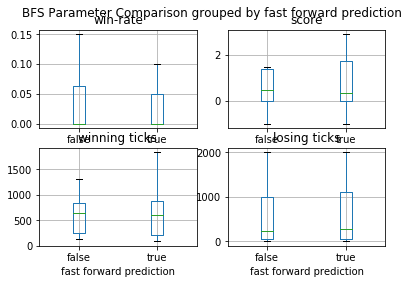

In [4]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, sharey="none")
df_BFS.boxplot(column=['win-rate'],ax = ax1, by='fast forward prediction', showfliers=False, return_type=None)
df_BFS.boxplot(column=['score'],ax = ax2, by='fast forward prediction', showfliers=False, return_type=None)
df_BFS.boxplot(column=['winning ticks'],ax = ax3, by='fast forward prediction', showfliers=False, return_type=None)
df_BFS.boxplot(column=['losing ticks'],ax = ax4, by='fast forward prediction', showfliers=False, return_type=None)

fig.suptitle("BFS Parameter Comparison grouped by fast forward prediction")

Text(0.5, 0.98, 'BFS Parameter Comparison grouped by pruning')

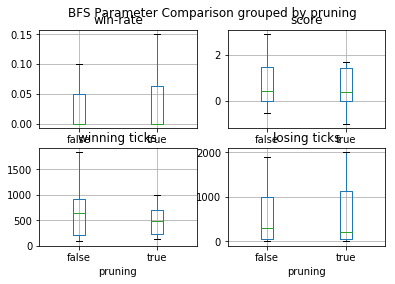

In [5]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, sharey="none")
df_BFS.boxplot(column=['win-rate'],ax = ax1, by='pruning', showfliers=False, return_type=None)
df_BFS.boxplot(column=['score'],ax = ax2, by='pruning', showfliers=False, return_type=None)
df_BFS.boxplot(column=['winning ticks'],ax = ax3, by='pruning', showfliers=False, return_type=None)
df_BFS.boxplot(column=['losing ticks'],ax = ax4, by='pruning', showfliers=False, return_type=None)

fig.suptitle("BFS Parameter Comparison grouped by pruning")

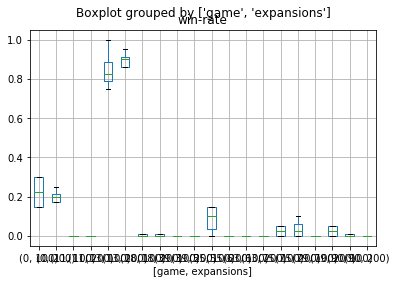

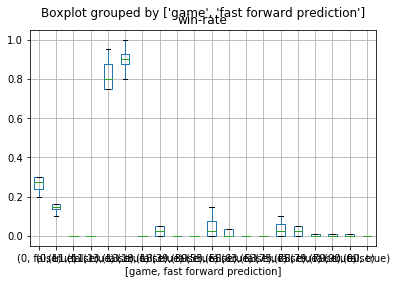

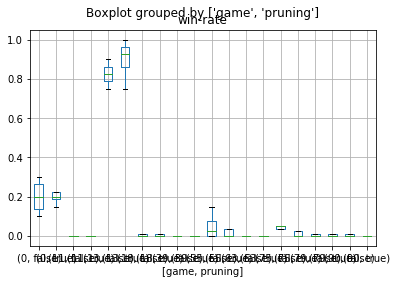

In [6]:
df_BFS.boxplot(column=['win-rate'], by=["game",'expansions'], showfliers=False, return_type=None)
df_BFS.boxplot(column=['win-rate'], by=["game",'fast forward prediction'], showfliers=False, return_type=None)
df_BFS.boxplot(column=['win-rate'], by=["game",'pruning'], showfliers=False, return_type=None)

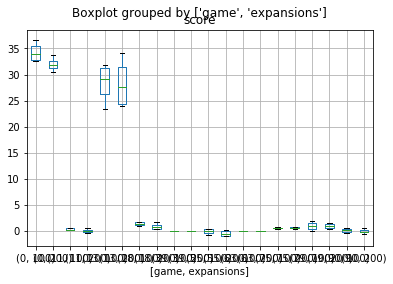

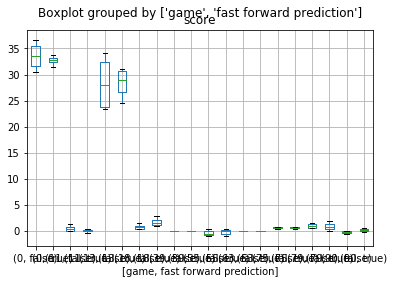

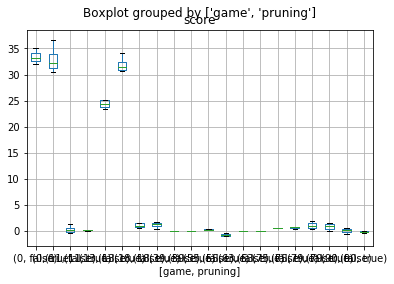

In [7]:
df_BFS.boxplot(column=['score'], by=["game",'expansions'], showfliers=False, return_type=None)
df_BFS.boxplot(column=['score'], by=["game",'fast forward prediction'], showfliers=False, return_type=None)
df_BFS.boxplot(column=['score'], by=["game",'pruning'], showfliers=False, return_type=None)

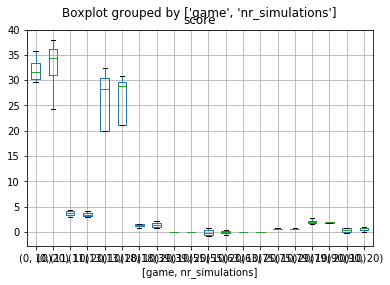

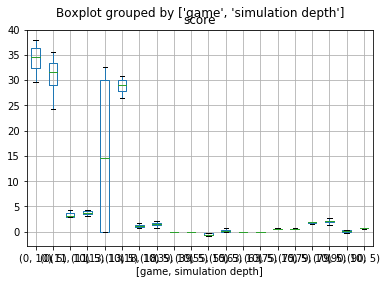

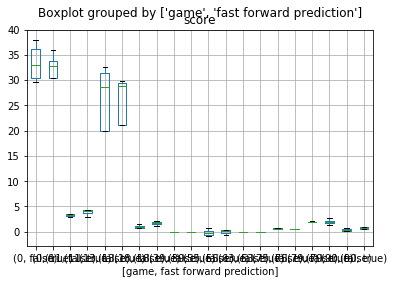

In [8]:
df_MCTS.boxplot(column=['score'], by=["game",'nr_simulations'], showfliers=False, return_type=None)
df_MCTS.boxplot(column=['score'], by=["game",'simulation depth'], showfliers=False, return_type=None)
df_MCTS.boxplot(column=['score'], by=["game",'fast forward prediction'], showfliers=False, return_type=None)

In [9]:
df_MCTS.groupby(["game", "nr_simulations"]).mean()
df_MCTS.groupby(["game", "simulation depth"]).mean()
a = df_MCTS.groupby(["game", "fast forward prediction"])

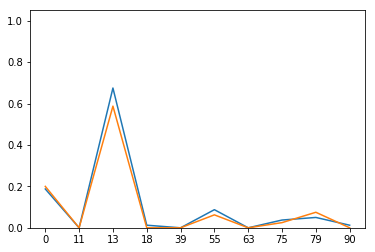

In [10]:
a = df_MCTS[df_MCTS["fast forward prediction"] == "true"].groupby("game").mean()["win-rate"]
b = df_MCTS[df_MCTS["fast forward prediction"] == "false"].groupby("game").mean()["win-rate"]
plt.plot(range(10), a)
plt.plot(range(10), b)
plt.ylim((0,1.05))
plt.xticks(range(10), game_ids)
plt.show()


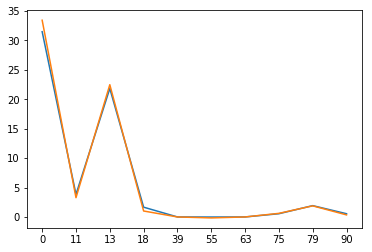

In [11]:
a = df_MCTS[df_MCTS["fast forward prediction"] == "true"].groupby("game").mean()["score"]
b = df_MCTS[df_MCTS["fast forward prediction"] == "false"].groupby("game").mean()["score"]
plt.plot(range(10), a)
plt.plot(range(10), b)
#plt.ylim((0,1.05))
plt.xticks(range(10), game_ids)
plt.show()


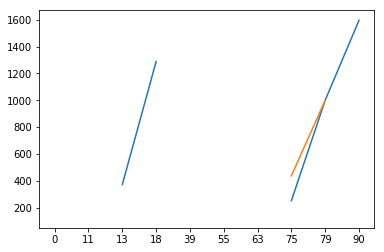

In [12]:
a = df_MCTS[df_MCTS["fast forward prediction"] == "true"].groupby("game").mean()["winning ticks"]
b = df_MCTS[df_MCTS["fast forward prediction"] == "false"].groupby("game").mean()["winning ticks"]
plt.plot(range(10), a)
plt.plot(range(10), b)
#plt.ylim((0,1.05))
plt.xticks(range(10), game_ids)
plt.show()



## MCTS parameter analysis

In [9]:
def plot_results_hierarchical(data, label, yaxis, ylim=None):
    from matplotlib.cm import get_cmap

    #plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.style.use("bmh")

    plt.gca().tick_params(axis='both', which='major', labelsize=12)
    plt.gca().tick_params(axis='both', which='major', labelsize=12)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_edgecolor('black')
    plt.gca().spines['bottom'].set_edgecolor('black')
    plt.gca().spines['left'].set_linewidth(1)
    plt.gca().spines['bottom'].set_linewidth(1)
    plt.gca().tick_params(color='black', labelcolor='black', bottom=True, left=True, which='both')
    plt.gca().set_facecolor("w")

    plt.gca().set_frame_on(True)

    plt.gca().xaxis.tick_bottom()
    plt.gca().yaxis.tick_left()

    cmap = [get_cmap("tab20b").colors[12], get_cmap("tab20b").colors[14],
            get_cmap("tab20b").colors[15]]

    plt.plot(range(10), data[0], label=label[0], linestyle="solid", marker="D", c=cmap[0], markersize=5)
    plt.plot(range(10), data[1], label=label[1], linestyle="dashed", marker="s", c=cmap[1], markersize=6)
    #plt.xlabel("game", fontsize=14)
    plt.ylabel(yaxis)
    plt.xticks(range(10), game_names, rotation=45,  ha="right")
    #plt.xticks(range(0, 260, 50), [str(i) if i % 50 == 0 else "" for i in range(0, 260, 50)], fontsize=14)
    #plt.yticks([0, 0.2, 0.4, 0.6, .8, 1.0], fontsize=14)
    #legend = plt.legend(fontsize=12, loc='upper right', title=legendtitle)
    #frame = legend.get_frame()
    #frame.set_facecolor('w')
    r = abs(max(max(data[0]),max(data[1])) - min(min(data[0]), min(data[1])))
    
    if ylim is not None:
        plt.ylim = ylim
        print(ylim)
    else:
        plt.ylim = (min(min(data[0]), min(data[1]))-0.05*r, max(max(data[0]),max(data[1]))+0.05*r)


    #plt.show()

## MCTS Parameter Analysis

(0, 0.85)


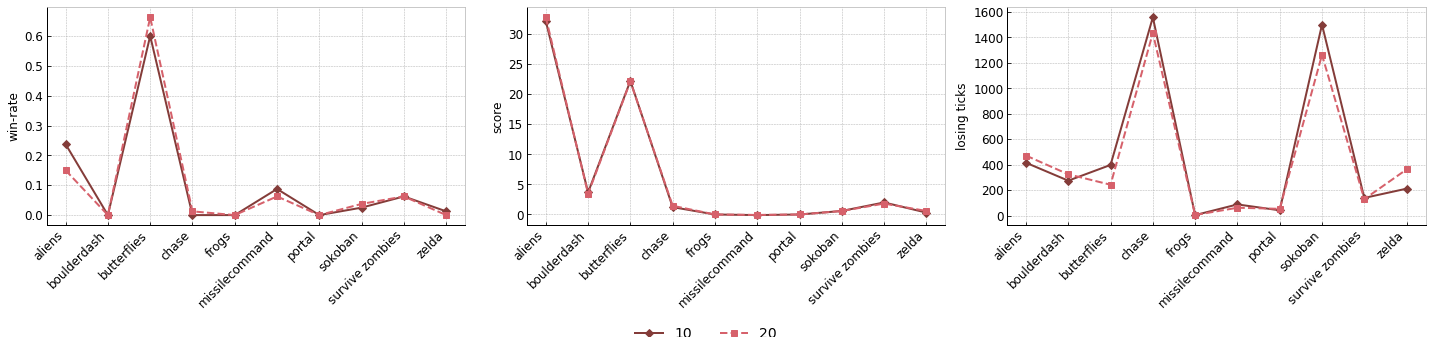

In [28]:
f = plt.figure(figsize=(20,4.5))

plt.subplot(131)

a = df_MCTS[df_MCTS["nr_simulations"] == "10"].groupby("game").mean()["win-rate"]
b = df_MCTS[df_MCTS["nr_simulations"] == "20"].groupby("game").mean()["win-rate"]

plot_results_hierarchical([a,b],[10, 20], "win-rate", (0, 0.85))
#plt.gca().set_yscale('log')


plt.subplot(132)

a = df_MCTS[df_MCTS["nr_simulations"] == "10"].groupby("game").mean()["score"]
b = df_MCTS[df_MCTS["nr_simulations"] == "20"].groupby("game").mean()["score"]

plot_results_hierarchical([a,b],[10, 20], "score")
#plt.gca().set_yscale('log')

plt.subplot(133)
a = df_MCTS[df_MCTS["nr_simulations"] == "10"].groupby("game").mean()["losing ticks"]
b = df_MCTS[df_MCTS["nr_simulations"] == "20"].groupby("game").mean()["losing ticks"]

plot_results_hierarchical([a,b],[10, 20], "ticks until loss")
#plt.gca().set_yscale('log')

handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.figlegend(handles, labels, loc = 'lower center', bbox_to_anchor=(0.49, -0.05), ncol=2, labelspacing=0., fontsize=14, frameon=False)
legend.get_frame().set_facecolor('w')
plt.tight_layout()

(0, 0.85)
(0, 0.85)
(0, 0.85)


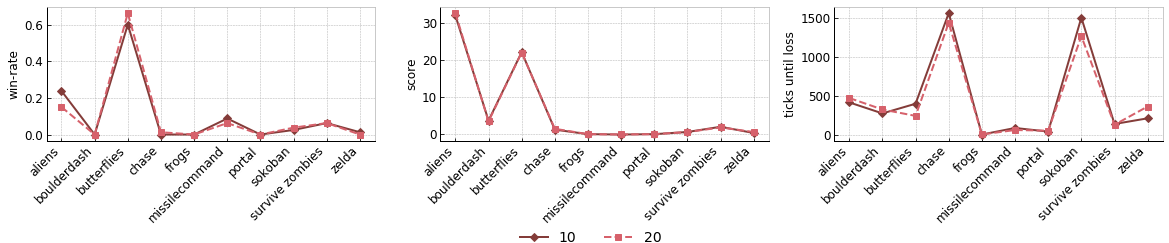

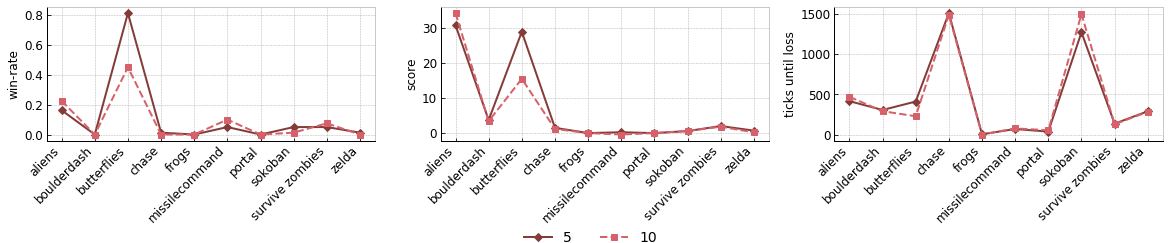

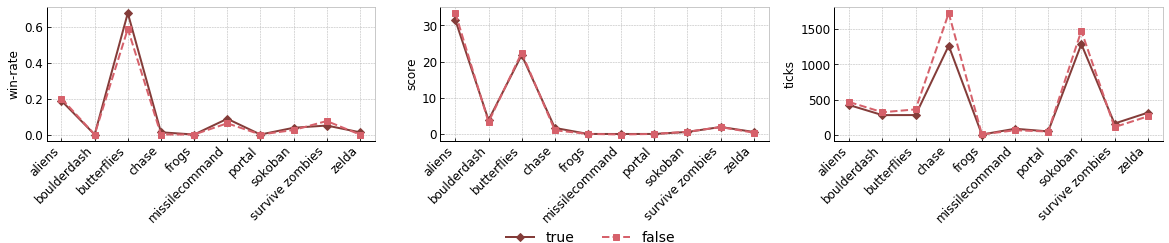

In [60]:
f = plt.figure(figsize=(20,3.5))

plt.subplot(131)

a = df_MCTS[df_MCTS["nr_simulations"] == "10"].groupby("game").mean()["win-rate"]
b = df_MCTS[df_MCTS["nr_simulations"] == "20"].groupby("game").mean()["win-rate"]

plot_results_hierarchical([a,b],[10, 20], "win-rate", (0, 0.85))
#plt.gca().set_yscale('log')


plt.subplot(132)

a = df_MCTS[df_MCTS["nr_simulations"] == "10"].groupby("game").mean()["score"]
b = df_MCTS[df_MCTS["nr_simulations"] == "20"].groupby("game").mean()["score"]

plot_results_hierarchical([a,b],[10, 20], "score")
#plt.gca().set_yscale('log')

plt.subplot(133)
a = df_MCTS[df_MCTS["nr_simulations"] == "10"].groupby("game").mean()["losing ticks"]
b = df_MCTS[df_MCTS["nr_simulations"] == "20"].groupby("game").mean()["losing ticks"]

plot_results_hierarchical([a,b],[10, 20], "ticks until loss")
#plt.gca().set_yscale('log')
plt.subplots_adjust(bottom=0.35)

handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.figlegend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.41, 0.1), ncol=2, labelspacing=0., fontsize=14, frameon=False)
legend.get_frame().set_facecolor('w')

plt.savefig("figures/mcts_nr_simulations.png", bbox_inches='tight')
plt.savefig("figures/mcts_nr_simulations.pdf", bbox_inches='tight')



f = plt.figure(figsize=(20,3.5))

plt.subplot(131)

a = df_MCTS[df_MCTS["simulation depth"] == "5"].groupby("game").mean()["win-rate"]
b = df_MCTS[df_MCTS["simulation depth"] == "10"].groupby("game").mean()["win-rate"]

plot_results_hierarchical([a,b],[5, 10], "win-rate",  (0, 0.85))
#plt.gca().set_yscale('log')


plt.subplot(132)

a = df_MCTS[df_MCTS["simulation depth"] == "5"].groupby("game").mean()["score"]
b = df_MCTS[df_MCTS["simulation depth"] == "10"].groupby("game").mean()["score"]

plot_results_hierarchical([a,b],[5, 10], "score")
#plt.gca().set_yscale('log')

plt.subplot(133)
a = df_MCTS[df_MCTS["simulation depth"] == "5"].groupby("game").mean()["losing ticks"]
b = df_MCTS[df_MCTS["simulation depth"] == "10"].groupby("game").mean()["losing ticks"]

plot_results_hierarchical([a,b],[5, 10], "ticks until loss")
#plt.gca().set_yscale('log')
plt.subplots_adjust(bottom=0.35)

handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.figlegend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.41, 0.1), ncol=2, labelspacing=0., fontsize=14, frameon=False)
legend.get_frame().set_facecolor('w')

plt.savefig("figures/mcts_simulation_depth.png", bbox_inches='tight')
plt.savefig("figures/mcts_simulation_depth.pdf", bbox_inches='tight')



f = plt.figure(figsize=(20,3.5))

plt.subplot(131)

a = df_MCTS[df_MCTS["fast forward prediction"] == "true"].groupby("game").mean()["win-rate"]
b = df_MCTS[df_MCTS["fast forward prediction"] == "false"].groupby("game").mean()["win-rate"]

plot_results_hierarchical([a,b],["true", "false"], "win-rate",  (0, 0.85))
#plt.gca().set_yscale('log')



plt.subplot(132)

a = df_MCTS[df_MCTS["fast forward prediction"] == "true"].groupby("game").mean()["score"]
b = df_MCTS[df_MCTS["fast forward prediction"] == "false"].groupby("game").mean()["score"]

plot_results_hierarchical([a,b],["true", "false"], "score")
#plt.gca().set_yscale('log')


plt.subplot(133)
a = df_MCTS[df_MCTS["fast forward prediction"] == "true"].groupby("game").mean()["losing ticks"]
b = df_MCTS[df_MCTS["fast forward prediction"] == "false"].groupby("game").mean()["losing ticks"]
plot_results_hierarchical([a,b],["true", "false"], "ticks")
#plt.gca().set_yscale('log')

handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.figlegend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.41, 0.1), ncol=2, labelspacing=0., fontsize=14, frameon=False)
legend.get_frame().set_facecolor('w')

plt.subplots_adjust(bottom=0.35)

plt.savefig("figures/mcts_macro_actions.png", bbox_inches='tight')
plt.savefig("figures/mcts_macro_actions.pdf", bbox_inches='tight')

## BFS Parameter Analysis

In [7]:
df_BFS

,game,alg,expansions,fast forward prediction,pruning,win-rate,score,winning ticks,losing ticks
0,0,BFS,100,false,false,0.30,35.05,648.333333,392.642857
1,0,BFS,100,false,true,0.30,36.70,646.500000,399.785714
2,0,BFS,100,true,false,0.15,32.65,642.666667,390.352941
3,0,BFS,100,true,true,0.15,32.95,556.000000,410.647059
4,0,BFS,200,false,false,0.25,32.10,643.600000,319.800000
...,...,...,...,...,...,...,...,...,...
147,90,BFS,100,true,true,0.00,-0.15,NaN,102.950000
148,90,BFS,200,false,false,0.00,-0.55,NaN,204.400000
149,90,BFS,200,false,true,0.00,-0.20,NaN,209.350000
150,90,BFS,200,true,false,0.00,-0.10,NaN,278.000000


(0, 0.85)
(0, 0.85)
(0, 0.85)


c:\program files\python37\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '
c:\program files\python37\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '
c:\program files\python37\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


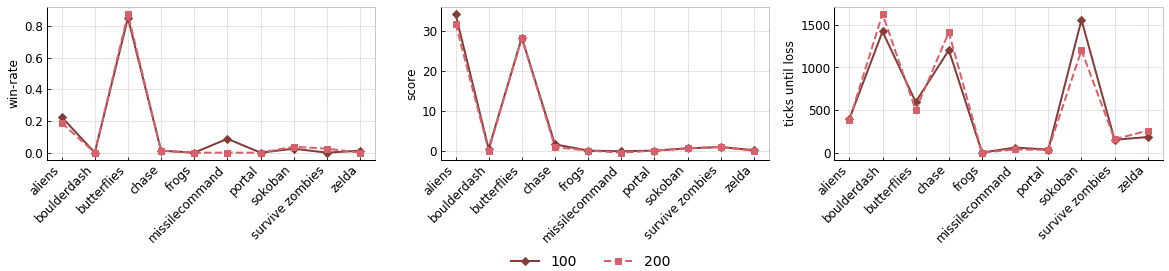

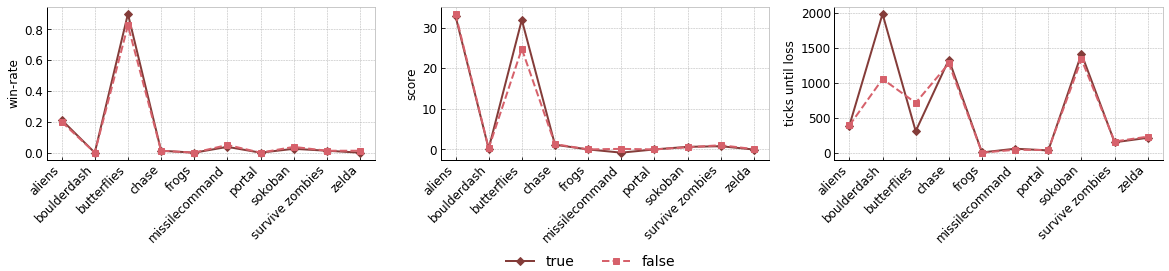

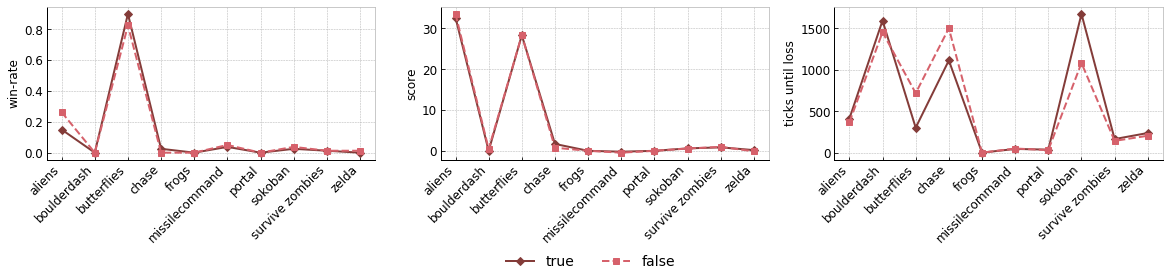

In [59]:
f = plt.figure(figsize=(20,4))

plt.subplot(131)

a = df_BFS[df_BFS["expansions"] == "100"].groupby("game").mean()["win-rate"]
b = df_BFS[df_BFS["expansions"] == "200"].groupby("game").mean()["win-rate"]

plot_results_hierarchical([a,b],[100, 200], "win-rate", (0, 0.85))
#plt.gca().set_yscale('log')


plt.subplot(132)

a = df_BFS[df_BFS["expansions"] == "100"].groupby("game").mean()["score"]
b = df_BFS[df_BFS["expansions"] == "200"].groupby("game").mean()["score"]

plot_results_hierarchical([a,b],[100, 200], "score")
#plt.gca().set_yscale('log')

plt.subplot(133)
a = df_BFS[df_BFS["expansions"] == "100"].groupby("game").mean()["losing ticks"]
b = df_BFS[df_BFS["expansions"] == "200"].groupby("game").mean()["losing ticks"]

plot_results_hierarchical([a,b],[100, 200], "ticks until loss")
#plt.gca().set_yscale('log')

handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.figlegend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.41, 0.1), ncol=2, labelspacing=0., fontsize=14, frameon=False)
legend.get_frame().set_facecolor('w')

plt.tight_layout(rect=[0,0.35,0.0,1])
plt.subplots_adjust(bottom=0.35)


plt.savefig("figures/bfs_expansions.png", bbox_inches='tight')
plt.savefig("figures/bfs_expansions.pdf", bbox_inches='tight')


f = plt.figure(figsize=(20,4))

plt.subplot(131)

a = df_BFS[df_BFS["pruning"] == "true"].groupby("game").mean()["win-rate"]
b = df_BFS[df_BFS["pruning"] == "false"].groupby("game").mean()["win-rate"]

plot_results_hierarchical([a,b],["true", "false"], "win-rate",  (0, 0.85))
#plt.gca().set_yscale('log')


plt.subplot(132)

a = df_BFS[df_BFS["pruning"] == "true"].groupby("game").mean()["score"]
b = df_BFS[df_BFS["pruning"] == "false"].groupby("game").mean()["score"]

plot_results_hierarchical([a,b],["true", "false"], "score")
#plt.gca().set_yscale('log')

plt.subplot(133)
a = df_BFS[df_BFS["pruning"] == "true"].groupby("game").mean()["losing ticks"]
b = df_BFS[df_BFS["pruning"] == "false"].groupby("game").mean()["losing ticks"]

plot_results_hierarchical([a,b],["true", "false"], "ticks until loss")
#plt.gca().set_yscale('log')
plt.subplots_adjust(bottom=0.35)

handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.figlegend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.41, 0.1), ncol=2, labelspacing=0., fontsize=14, frameon=False)
legend.get_frame().set_facecolor('w')

plt.tight_layout(rect=[0,0.35,0.0,1])
plt.subplots_adjust(bottom=0.35)


plt.savefig("figures/bfs_pruning.png", bbox_inches='tight')
plt.savefig("figures/bfs_pruning.pdf", bbox_inches='tight')



f = plt.figure(figsize=(20,4))

plt.subplot(131)

a = df_BFS[df_BFS["fast forward prediction"] == "true"].groupby("game").mean()["win-rate"]
b = df_BFS[df_BFS["fast forward prediction"] == "false"].groupby("game").mean()["win-rate"]

plot_results_hierarchical([a,b],["true", "false"], "win-rate",  (0, 0.85))
#plt.gca().set_yscale('log')


plt.subplot(132)

a = df_BFS[df_BFS["fast forward prediction"] == "true"].groupby("game").mean()["score"]
b = df_BFS[df_BFS["fast forward prediction"] == "false"].groupby("game").mean()["score"]

plot_results_hierarchical([a,b],["true", "false"], "score")
#plt.gca().set_yscale('log')

plt.subplot(133)
a = df_BFS[df_BFS["fast forward prediction"] == "true"].groupby("game").mean()["losing ticks"]
b = df_BFS[df_BFS["fast forward prediction"] == "false"].groupby("game").mean()["losing ticks"]
plot_results_hierarchical([a,b],["true", "false"], "ticks until loss")
#plt.gca().set_yscale('log')



handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.41, 0.1), ncol=2, labelspacing=0., fontsize=14, frameon=False)
legend.get_frame().set_facecolor('w')

plt.tight_layout(rect=[0,0.35,0.0,1])
plt.subplots_adjust(bottom=0.35)

plt.savefig("figures/bfs_macro_actions.png", bbox_inches='tight')
plt.savefig("figures/bfs_macro_actions.pdf", bbox_inches='tight')



## Agent Rankings

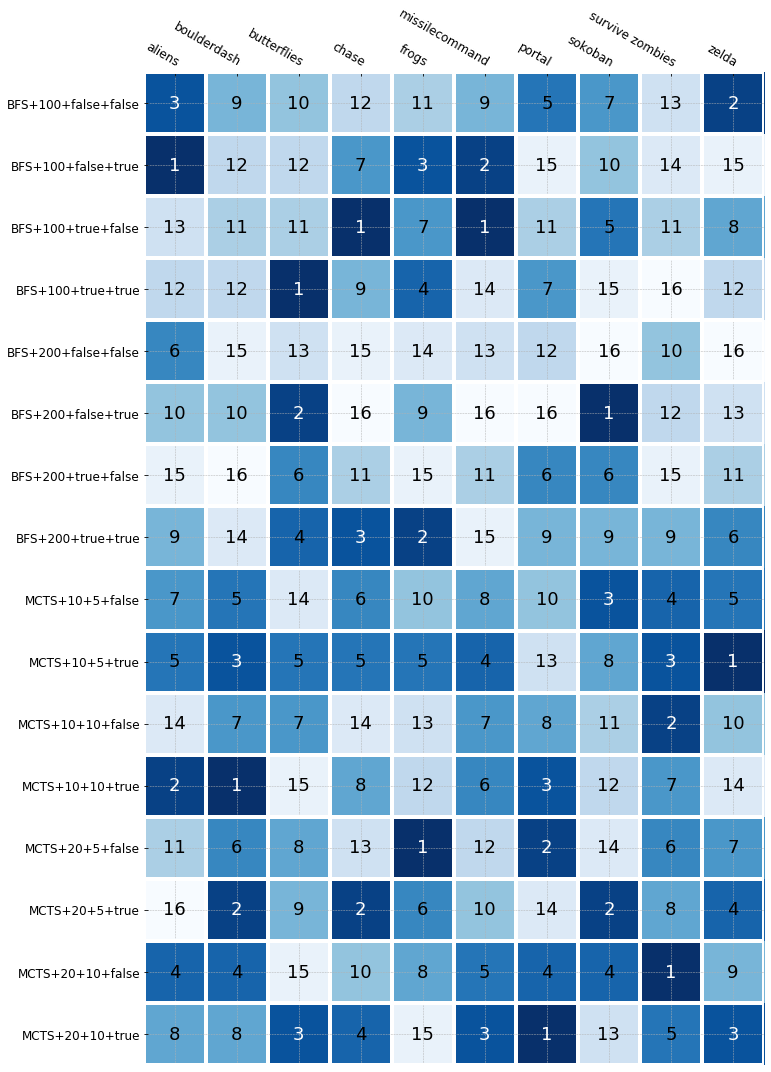

In [16]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

#plt.rc('pgf', texsystem='lualatex')
#plt.rc('text', usetex=True)
#plt.rc('text.latex',
#       preamble=r'\usepackage{amsmath}\usepackage{kmath}\usepackage{kerkis}\renewcommand\sfdefault\rmdefault')
#font_path = '/home/alex/fonts/kerkis.ttf'
#prop = font_manager.FontProperties(fname=font_path)

grid = dict(height_ratios=[5], width_ratios=[15])
fig, ax = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid)
fig.set_figheight(15)
fig.set_figwidth(13)
im, cbar = heatmap(game_results.transpose() + 1,
                   ["+".join(x) for x in parameter_settings],
                   game_names, ax=ax, vmin=1, vmax=16, cbar=False, cmap=plt.cm.get_cmap('Blues_r', 16),
                   cbar_kw={"ticks": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]})
annotate_heatmap(im, game_results.transpose() + 1, valfmt="{x:1.0f}", threshold=1, threshold2=3)
plt.tight_layout()
plt.savefig("figures/agent-ranks.pdf")
plt.savefig("figures/agent-ranks.png")
plt.show()


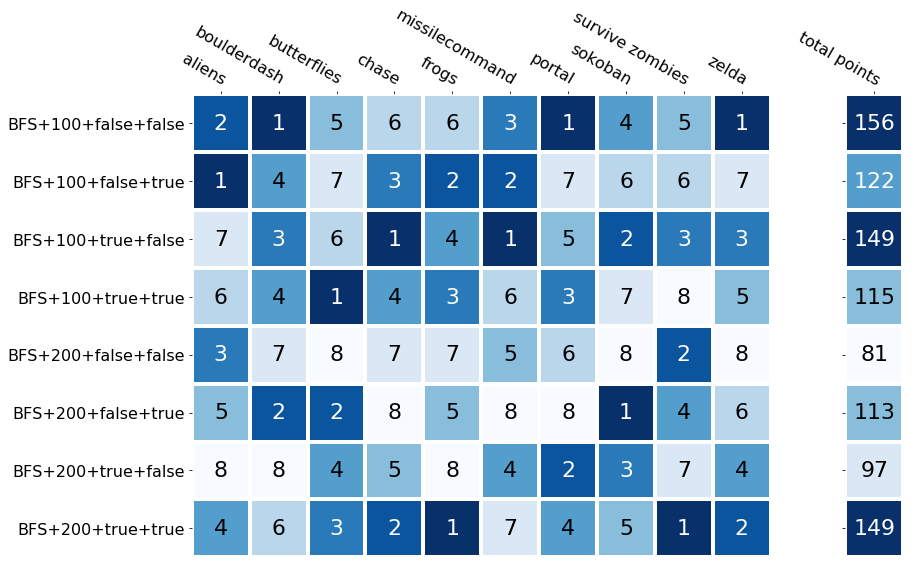

In [8]:
game_names = ["aliens", "boulderdash", "butterflies", "chase", "frogs",
              "missilecommand", "portal", "sokoban", "survive zombies", "zelda"]
game_ids = [0, 11, 13, 18, 39, 55, 63, 75, 79, 90]
parameter_settings = [["BFS", "100", "false", "false"],
                      ["BFS", "100", "false", "true"],
                      ["BFS", "100", "true", "false"],
                      ["BFS", "100", "true", "true"],
                      ["BFS", "200", "false", "false"],
                      ["BFS", "200", "false", "true"],
                      ["BFS", "200", "true", "false"],
                      ["BFS", "200", "true", "true"]
                     ]

ranks = [[0] * 8, [0] * 8, [0] * 8, [0] * 8, [0] * 8, [0] * 8, [0] * 8, [0] * 8]
points = [0] * 8
game_results = np.zeros((10, 8))
formula = {0: 25, 1: 18, 2: 15, 3: 12, 4: 10, 5: 8, 6: 6, 7: 4, 8: 2, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14:0, 15:0}


all_results = dict()
for (game_idx, game_id), game in zip(enumerate(game_ids), game_names):
    all_results[game_id] = []
    for parameter_setting in parameter_settings:
        results = load_file(game_id, parameter_setting)
        all_results[game_id].append(results)

    store_file(game_id, all_results[game_id], parameter_settings)


    res = [[idx] + [round(y, 2) for y in all_results[game_id][idx]] for idx, _ in enumerate(all_results[game_id])]
    for ind, x in enumerate(res):
        if math.isnan(x[3]):
            res[ind][3] = 10000
        if math.isnan(x[4]):
            res[ind][4] = 10000

    o = sorted(range(len(res)), key=lambda k: (res[k][1], res[k][2], -res[k][3], res[k][4]), reverse=True)
    rank = [0] * 16
    current_rank = 0
    skip = 1
    for io in range(len(o) - 1):
        rank[o[io]] = current_rank
        if res[o[io]][1:15] != res[o[io + 1]][1:15]:
            current_rank += skip
            skip = 1
        else:
            skip += 1
    rank[o[-1]] = current_rank

    # print(game, [res[x][0] for x in o])

    for io, x in enumerate(o):
        ##for p, x in zip([5, 4, 3, 2, 1], o):
        # print(points, res[x][0])
        points[res[x][0]] += formula[rank[o[io]]]

    for j, x in enumerate(o):
        # print(i, x)
        ranks[res[x][0]][rank[o[j]]] += 1
        game_results[game_idx, res[x][0]] = rank[o[j]]

import sys, importlib
importlib.reload(sys.modules['plot_gameplay_results'])
from plot_gameplay_results import heatmap, annotate_heatmap
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

grid = dict(height_ratios=[5], width_ratios=[8,1])
fig, [ax0, ax1] = plt.subplots(ncols=2, nrows=1, gridspec_kw=grid)
fig.set_figheight(8)
fig.set_figwidth(13)
im, cbar = heatmap(game_results.transpose() + 1,
                   ["+".join(x) for x in parameter_settings],
                   game_names, ax=ax0, vmin=1, vmax=8, cbar=False, cmap=plt.cm.get_cmap('Blues_r', 8),
                   cbar_kw={"ticks": [1, 2, 3, 4, 5, 6, 7, 8]})
annotate_heatmap(im, game_results.transpose() + 1, valfmt="{x:1.0f}", threshold=1, threshold2=3, fontsize=22)
plt.gca().grid(False)


im, cbar = heatmap(np.array(points).transpose().reshape(8,1),
                   ["","","","","","","",""],
                   ["total points"], ax=ax1, vmin=min(points), vmax=max(points), cbar=False, cmap=plt.cm.get_cmap('Blues', 8),
                   cbar_kw={"ticks": [1, 2, 3, 4, 5, 6, 7, 8]})

annotate_heatmap(im, np.array(points).transpose().reshape(8,1), fontsize=22,valfmt="{x:1.0f}", threshold=120, threshold2=300)
plt.gca().grid(False)

ax = plt.gca()
ax.set_xticklabels(["total points"])
ax.tick_params(top=True, bottom=False,
                       labeltop=True, labelbottom=False)

plt.tight_layout()
plt.savefig("figures/agent-ranks-bfs.pdf")
plt.savefig("figures/agent-ranks-bfs.png")
plt.show()

In [13]:
print(all_results[0][0])

(0.3, 35.05, 648.3333333333334, 392.64285714285717)


In [18]:

game_names = ["aliens", "boulderdash", "butterflies", "chase", "frogs",
              "missilecommand", "portal", "sokoban", "survive zombies", "zelda"]
game_ids = [0, 11, 13, 18, 39, 55, 63, 75, 79, 90]
parameter_settings = [["MCTS", "10", "5", "false"],
                      ["MCTS", "10", "5", "true"],
                      ["MCTS", "10", "10", "false"],
                      ["MCTS", "10", "10", "true"],
                      ["MCTS", "20", "5", "false"],
                      ["MCTS", "20", "5", "true"],
                      ["MCTS", "20", "10", "false"],
                      ["MCTS", "20", "10", "true"]
                     ]

ranks = [[0] * 8, [0] * 8, [0] * 8, [0] * 8, [0] * 8, [0] * 8, [0] * 8, [0] * 8]
points = [0] * 8
game_results = np.zeros((10, 8))
formula = {0: 25, 1: 18, 2: 15, 3: 12, 4: 10, 5: 8, 6: 6, 7: 4, 8: 2, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14:0, 15:0}


all_results = dict()
for (game_idx, game_id), game in zip(enumerate(game_ids), game_names):
    all_results[game_id] = []
    for parameter_setting in parameter_settings:
        results = load_file(game_id, parameter_setting)
        all_results[game_id].append(results)

    store_file(game_id, all_results[game_id], parameter_settings)


    res = [[idx] + [round(y, 2) for y in all_results[game_id][idx]] for idx, _ in enumerate(all_results[game_id])]
    for ind, x in enumerate(res):
        if math.isnan(x[3]):
            res[ind][3] = 10000
        if math.isnan(x[4]):
            res[ind][4] = 10000

    o = sorted(range(len(res)), key=lambda k: (res[k][1], res[k][2], -res[k][3], res[k][4]), reverse=True)
    rank = [0] * 16
    current_rank = 0
    skip = 1
    for io in range(len(o) - 1):
        rank[o[io]] = current_rank
        if res[o[io]][1:15] != res[o[io + 1]][1:15]:
            current_rank += skip
            skip = 1
        else:
            skip += 1
    rank[o[-1]] = current_rank

    # print(game, [res[x][0] for x in o])

    for io, x in enumerate(o):
        ##for p, x in zip([5, 4, 3, 2, 1], o):
        # print(points, res[x][0])
        points[res[x][0]] += formula[rank[o[io]]]

    for j, x in enumerate(o):
        # print(i, x)
        ranks[res[x][0]][rank[o[j]]] += 1
        game_results[game_idx, res[x][0]] = rank[o[j]]


c:\program files\python37\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\program files\python37\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
for x in all_results:
    print(x, all_results[x][1])

0 (0.25, 32.55, 693.8, 405.1333333333333)
11 (0.0, 3.95, nan, 278.6)
13 (0.9, 29.8, 496.44444444444446, 399.5)
18 (0.0, 1.55, nan, 1233.25)
39 (0.0, 0.0, nan, 5.85)
55 (0.1, 0.3, 142.5, 97.94444444444444)
63 (0.0, 0.0, nan, 31.65)
75 (0.05, 0.5, 378.0, 1720.6315789473683)
79 (0.05, 2.65, 1000.0, 152.05263157894737)
90 (0.05, 0.7, 1596.0, 188.57894736842104)


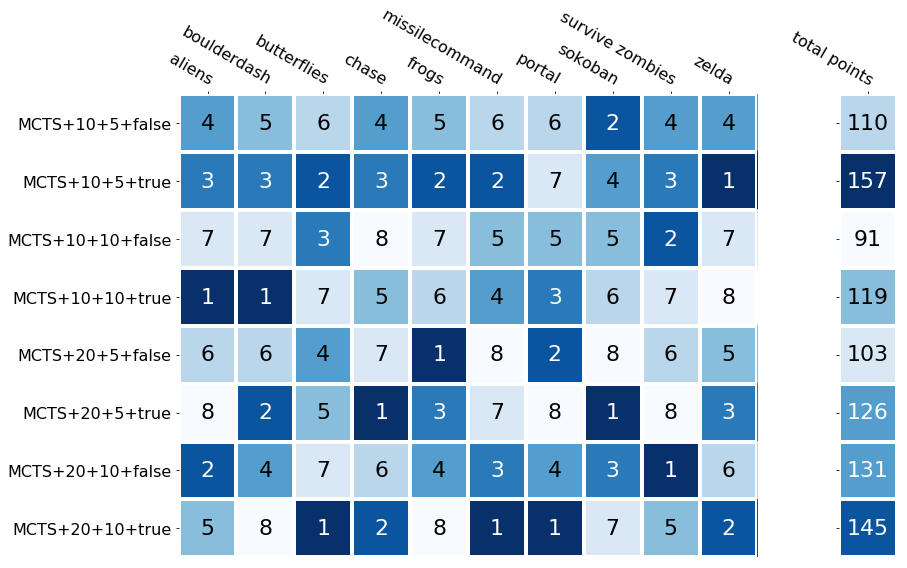

In [4]:
import sys, importlib
importlib.reload(sys.modules['plot_gameplay_results'])
from plot_gameplay_results import heatmap, annotate_heatmap
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager


grid = dict(height_ratios=[5], width_ratios=[8,1])
fig, [ax0, ax1] = plt.subplots(ncols=2, nrows=1, gridspec_kw=grid)
fig.set_figheight(8)
fig.set_figwidth(13)
im, cbar = heatmap(game_results.transpose() + 1,
                   ["+".join(x) for x in parameter_settings],
                   game_names, ax=ax0, vmin=1, vmax=8, cbar=False, cmap=plt.cm.get_cmap('Blues_r', 8),
                   cbar_kw={"ticks": [1, 2, 3, 4, 5, 6, 7, 8]})
annotate_heatmap(im, game_results.transpose() + 1, valfmt="{x:1.0f}", threshold=1, threshold2=3, fontsize=22)
plt.gca().grid(False)


im, cbar = heatmap(np.array(points).transpose().reshape(8,1),
                   ["","","","","","","",""],
                   ["total points"], ax=ax1, vmin=min(points), vmax=max(points), cbar=False, cmap=plt.cm.get_cmap('Blues', 8),
                   cbar_kw={"ticks": [1, 2, 3, 4, 5, 6, 7, 8]})

annotate_heatmap(im, np.array(points).transpose().reshape(8,1), fontsize=22,valfmt="{x:1.0f}", threshold=120, threshold2=300)
plt.gca().grid(False)

ax = plt.gca()
ax.set_xticklabels(["total points"])
ax.tick_params(top=True, bottom=False,
                       labeltop=True, labelbottom=False)

plt.tight_layout()
plt.savefig("figures/agent-ranks-mcts.pdf")
plt.savefig("figures/agent-ranks-mcts.png")
plt.show()
